In [ ]:
# Создаем папку для checkpoint'ов с весами.
!mkdir checkpoints

#Скачиваем файл с весами для YOLOv3 с официального сайта.
!wget https://pjreddie.com/media/files/yolov3.weights

# Импортируем необходимые библиотеки.
import cv2
import numpy as np

from absl import logging
from itertools import repeat
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

mkdir: cannot create directory ‘checkpoints’: File exists
--2023-04-10 10:30:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.3’

yolov3.weights.3    100%[===================>] 236.52M  17.1MB/s    in 14s     

2023-04-10 10:30:36 (17.3 MB/s) - ‘yolov3.weights.3’ saved [248007048/248007048]



In [ ]:
from google.colab.patches import cv2_imshow

from keras import Model
from keras.layers import Add, Concatenate, Lambda, BatchNormalization
from keras.layers import Conv2D, Input, LeakyReLU
from keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

yolo_iou_threshold = 0.6 # Intersection Over Union (iou) threshold.
yolo_score_threshold = 0.6 # Score threshold.

weightyolov3 = 'yolov3.weights' # Путь до файла с весами.
size = 416 # Размер изображения. 
checkpoints = 'checkpoints/yolov3.tf' # Путь до файла с checkpoint'ом.
num_classes = 80 # Количество классов в модели.

# Список слоев в YOLOv3 Fully Convolutional Network (FCN).
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2'
]

In [ ]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))
            
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4*filters)
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weights'
    wf.close()

In [ ]:
# Функция для расчета IoU.
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area
 
class BatchNormalization(BatchNormalization):
    def call(self, x, training=False):
        if training is None: training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

# Определяем 3 anchor box'а для каждой ячейки.   
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


In [ ]:
# Функция для отрисовки bounding box'ов.
def draw_outputs(img, outputs, class_names, white_list=None):
    boxes, score, classes, nums = outputs
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        if class_names[int(classes[i])] not in white_list:
            continue
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    previous = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([previous , x])
    return x

def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in repeat(None, blocks):
        x = DarknetResidual(x, filters)       
    return x

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)
    x = x_36 = DarknetBlock(x, 256, 8)
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return Model(inputs, (x_36, x_61, x), name=name)
  
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv
  
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    
    return bbox, score, class_probs, pred_box

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs
  
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold)
  
    return boxes, scores, classes, valid_detections

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        obj_mask = tf.squeeze(true_obj, -1)

        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [ ]:
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

In [ ]:
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightyolov3)

yolo.save_weights(checkpoints)

'''
class_names =  ['человек', 'велосипед', 'автомобиль', 'мотоцикл', 'самолет', 'автобус', 'поезд', 'грузовик',
     'катер', 'светофор', 'пожарный гидрант', 'стоп-сигнал', 'паркомат', 'скамейка',
     'птица', 'кошка', 'собака', 'лошадь', 'овца', 'корова', 'слон', 'медведь', 'зебра', 'жираф',
     'рюкзак', 'зонт', 'сумочка', 'галстук', 'чемодан', 'фрисби', 'лыжи', 'сноуборд',
     'спортивный мяч', 'воздушный змей', 'бейсбольная бита', 'бейсбольная перчатка', 'скейтборд', 'доска для серфинга',
     'теннисная ракетка', 'бутылка', 'бокал', 'чашка', 'вилка', 'нож', 'ложка', 'миска',
     'банан', 'яблоко', 'бутерброд', 'апельсин', 'брокколи', 'морковь', 'хот-дог', 'пицца', 'пончик',
     'торт', 'стул', 'диван', 'горшечное растение', 'кровать', 'обеденный стол', 'туалет', 'монитор', 'ноутбук',
     'мышь', 'пульт', 'клавиатура', 'сотовый телефон', 'микроволновая печь', 'духовка', 'тостер', 'раковина',
     'холодильник', 'книга', 'часы', 'ваза', 'ножницы', 'плюшевый мишка', 'фен', 'зубная щетка']
'''

class_names = ["person", "bicycle", "car", "motorbike", "airplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", 
    "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

def detect_objects(img_path, white_list=None):
    image = img_path     # Путь к изображению.
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3)

    img = tf.expand_dims(img, 0)
    img = preprocess_image(img, size)
    boxes, scores, classes, nums = yolo(img)

    img = cv2.imread(image)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list)

    cv2.imwrite('detected_{:}'.format(img_path), img)

    detected = Image.open('detected_{:}'.format(img_path))
    plt.figure(figsize=(8,8), dpi=90)
    plt.imshow(detected)
    plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

Saving cats_dogs.jpg to cats_dogs (1).jpg
Saving klass.jpg to klass (1).jpg
Saving Кафе.jpg to Кафе (1).jpg
Saving Кафе2.jpg to Кафе2 (1).jpg
Saving Овцы.jpg to Овцы (1).jpg
Saving Улица.jpg to Улица (1).jpg
Saving Ферма.mp4 to Ферма (1).mp4
Файл(ы) "cats_dogs.jpg" размером 238264 байт загружен(ы)
Файл(ы) "klass.jpg" размером 62450 байт загружен(ы)
Файл(ы) "Кафе.jpg" размером 38264 байт загружен(ы)
Файл(ы) "Кафе2.jpg" размером 155061 байт загружен(ы)
Файл(ы) "Овцы.jpg" размером 156769 байт загружен(ы)
Файл(ы) "Улица.jpg" размером 829789 байт загружен(ы)
Файл(ы) "Ферма.mp4" размером 26665739 байт загружен(ы)


In [ ]:
import yaml
import datetime
import os
import torch
import warnings
#import logging
import glob

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, device='cpu')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-10 Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def check_threshold_level(img, threshold_level):
    threshold_level = threshold_level - 1
    marker = True
    results = model(img)
    # модель возвращает нам все распознанные объекты, из которых нам нужны только люди, поэтому отфильтруем результат
    df = results.pandas().xyxy[0]
    df = df.drop(df[df.confidence < 0.4].index)
    persons = df
    # удалим лишние столбцы
    #persons = persons.drop(['name', 'class', 'confidence'], axis=1)
    if len(persons) == 0:
        # на фото нет людей
        return
    # переведем в int все значения координат
    persons[['xmin','ymin','xmax','ymax','class']] = persons[['xmin','ymin','xmax','ymax','class']].astype('int32')
    # 0 не может быть координатой, заменим на 1
    for column in persons.columns.tolist():  
        persons.loc[persons[column] == 0, column] = 1
    i = 0
    # конвертируем данные в массив numpy для последующей построчной обработки
    points_array = persons.to_numpy()
    uniq_items = df.drop_duplicates(subset=['name'], keep='first')
    uniq_items_list = uniq_items['name'].tolist()
    count_list = [0]*len(uniq_items_list)
    print(uniq_items_list)
    print(count_list)
    for row in points_array:
        index = uniq_items_list.index(row[6])
        count_list[index]+=1
        # получаем координаты человека и выберем цвет: зеленый, если нет превышения, желтый, 
        # если на фото количество людей равно порогу и красный, если количество превышает пороговое значение
        xmin, ymin, xmax, ymax = row[0:4]
        # рисуем границы
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax),
                          color=(row[5]*3,row[5]*3,row[5]*3), thickness=2)
        # и подписываем                           
        cv2.putText(img, str(count_list[index])+'/'+str(row[5]),
                        (xmin+5, ymin - 5),
                        cv2.FONT_HERSHEY_DUPLEX,
                        fontScale=1,
                        thickness=2,
                        color=(row[5]*3,row[5]*3,row[5]*3))
        i += 1
        
    print(count_list)
    if marker:
        return img,df


['chair', 'laptop', 'mouse', 'tv', 'keyboard']
[0, 0, 0, 0, 0]
[4, 7, 1, 1, 1]


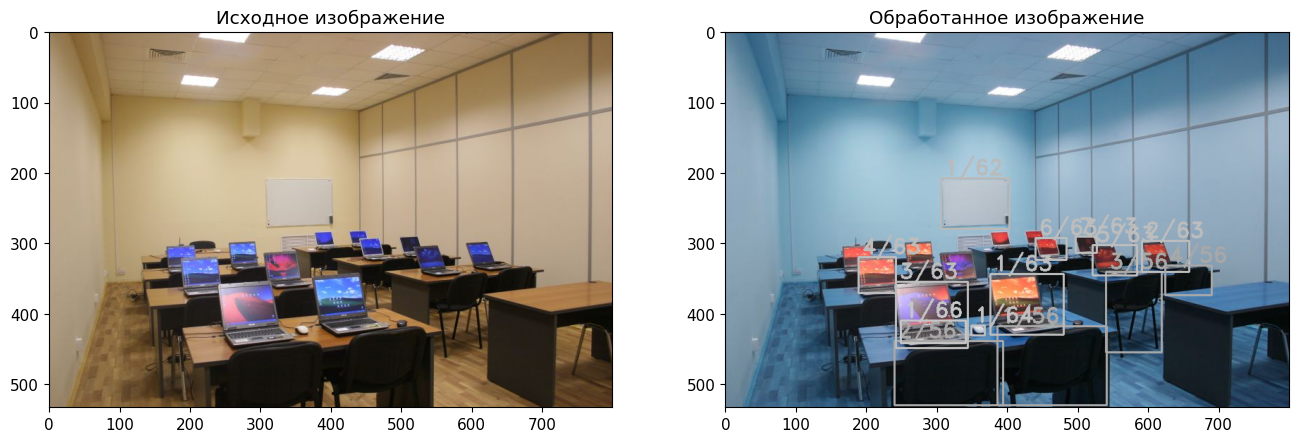

In [44]:
plt.figure(figsize=(16,13), dpi=100)
plt.subplot2grid((2,2),(0,0))

img = cv2.imread('klass.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img,df = check_threshold_level(img, 2)
if img is None:
    print('На фото людей не найдено')
    img2 = cv2.cvtColor(cv2.imread('nodata.png'), cv2.COLOR_BGR2RGB)
else:
    img2 = img
plt.title('Исходное изображение')
plt.subplot2grid((2,2),(0,1))
plt.imshow(img2)
plt.title('Обработанное изображение')
plt.show()

In [ ]:
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,386,418,541,530,0.856905,56,chair
1,240,439,394,530,0.845825,56,chair
2,376,344,480,430,0.826574,63,laptop
3,540,341,619,455,0.807269,56,chair
4,591,297,658,341,0.795668,63,laptop
5,242,355,344,449,0.787767,63,laptop
6,349,417,368,431,0.721643,64,mouse
7,306,208,403,280,0.684754,62,tv
8,189,320,242,371,0.647354,63,laptop
9,521,303,584,346,0.618376,63,laptop


In [62]:
import pandas as pd
capImg = cv2.VideoCapture('Ферма.mp4') #связываем видеопоток с переменной
count = 0
uniq_items = []
count_list = []
count_in_frames = []
# get total number of frames
totalFrames = capImg.get(cv2.CAP_PROP_FRAME_COUNT)
print(totalFrames)
while(capImg.isOpened()): #открываем файл с видео
  count += 1
  ret, frame = capImg.read() #получаем кадры из видеопотока файла, по очереди считываются в переменную frame
  if frame is None or count>500: #если кадры закончились, то прерываем цикл
    break
  results = model(frame)
  # модель возвращает нам все распознанные объекты, из которых нам нужны только люди, поэтому отфильтруем результат
  df_2 = results.pandas().xyxy[0]
  df_2 = df_2.drop(df_2[df_2.confidence < 0.6].index)
  test = df_2.groupby('name').size() 
  df_2 = df_2.drop_duplicates(subset=['name'], keep='first')
  if count == 69:
    #print(test)
    #print(df_2)
  if test.any():
      L = []
      for x in test:
         L.append(x)
      #print(count)
      df_2['count'] = L
  df_2['frame'] = count
  if count==1:
    my_df = df_2.copy()
  else:
    #print('HEAD')
    #print(my_df.head())
    #print(df_2.head())
    my_df = pd.concat([my_df, df_2], ignore_index=True)
    #print(my_df)
my_df

1080.0
39
40
43
49
50
51
68
name
cow    2
dtype: int64
         xmin        ymin        xmax        ymax  confidence  class name
0  872.089661  360.055756  917.242615  425.630768    0.667501     19  cow
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


482
483
484
485


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
639
640
641
642
643
644


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


<ipython-input-62-07154a65e869>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['count'] = L
<ipython-input-62-07154a65e869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['frame'] = count


901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000


,xmin,ymin,xmax,ymax,confidence,class,name,frame,count
0,508.267853,453.714172,624.260254,528.043884,0.629063,2,car,39,1.0
1,509.345093,453.829498,626.200073,531.194824,0.604212,2,car,40,1.0
2,511.601746,460.350769,630.021545,539.396179,0.707418,2,car,43,1.0
3,512.436584,473.423218,634.920593,556.634521,0.684631,2,car,49,1.0
4,511.276062,473.740265,636.968445,559.912842,0.640730,2,car,50,1.0
...,...,...,...,...,...,...,...,...,...
1226,1.068947,249.181091,205.098297,381.893738,0.903587,19,cow,996,4.0
1227,0.699280,248.697632,197.075394,383.182556,0.905833,19,cow,997,4.0
1228,0.144150,247.773346,185.378326,382.130707,0.904312,19,cow,998,4.0
1229,0.000000,250.207947,177.205078,382.105469,0.895816,19,cow,999,4.0


In [63]:
df_2[df_2['count']== df_2['count'].max()]

,xmin,ymin,xmax,ymax,confidence,class,name,count,frame
0,0.0,253.489105,170.702301,381.824982,0.903975,19,cow,4,1000
